## Brain Imaginary Hackathon (Signal to Image Pipeline)

### Import Area

In [1]:
from PIL import Image
from pathlib import Path

import numpy as np
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

### Create Label for Training

In [16]:
Topo_map= list(Path("/home/hpcnc/cloud/SuperAI/Hack-Brain-Imagery/topological/train").glob("*.png"))
create_label = []
create_file = []
for filename in Topo_map:
    temp = str(filename).split("_")[-2]
    file_path = str(filename).split("/")[-1]
    if temp == "110":
        create_file.append(file_path)
        create_label.append(0)
    elif temp == "120":
        create_file.append(file_path)
        create_label.append(1)
    elif temp == "150":
        create_file.append(file_path)
        create_label.append(2)


In [17]:
import csv

def save_to_csv(file_paths, labels, output_file):
    assert len(file_paths) == len(labels), "จำนวนของ file paths และ labels ต้องเท่ากัน"
    
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['file_path', 'label']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        for file_path, label in zip(file_paths, labels):
            writer.writerow({'file_path': file_path, 'label': label})

output_file = 'topolabel.csv'

save_to_csv(create_file, create_label, output_file)

In [2]:
df = pd.read_csv("/home/hpcnc/cloud/SuperAI/Hack-Brain-Imagery/topolabel.csv")
df

,file_path,label
0,s2_d2_p007_008_topomap_120_segment22.png,1
1,s2_d2_p011_001_topomap_120_segment22.png,1
2,s2_d2_p002_002_topomap_120_segment25.png,1
3,s2_d3_p013_008_topomap_150_segment13.png,2
4,s2_d2_p009_003_topomap_120_segment4.png,1
...,...,...
5713,s2_d2_p010_002_topomap_150_segment20.png,2
5714,s1_d3_p013_004_topomap_120_segment6.png,1
5715,s2_d3_p014_006_topomap_110_segment1.png,0
5716,s2_d2_p011_008_topomap_110_segment23.png,0


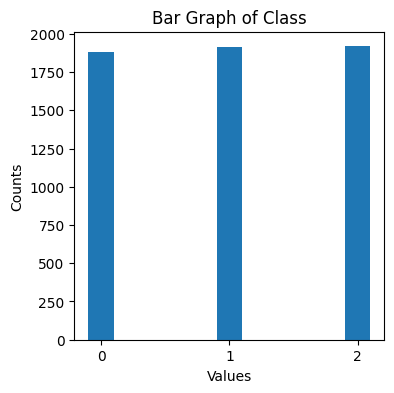

In [3]:
L = list(df['label'])
plt.figure(figsize=(4,4))
counts = [L.count(0), L.count(1), L.count(2)]
labels = [0, 1, 2]

plt.bar(labels, counts, tick_label=labels,width=0.2)
plt.xlabel('Values')
plt.ylabel('Counts')
plt.title('Bar Graph of Class')
plt.show()


### Prepare Dataset

In [4]:
images_path = "/home/hpcnc/cloud/SuperAI/Hack-Brain-Imagery/topological/train/"

import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset

class MyDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = self.dataframe.iloc[index, 0]  #. ใช้ index เพื่อเข้าถึงคอลัมน์ path
        # print(self.image_dir ,img_name)
        img_path = self.image_dir + img_name
        img = Image.open(img_path).convert('RGB')

        label = self.dataframe.iloc[index, 1]     #. ใช้ index เพื่อเข้าถึงคอลัมน์ label
        
        if self.transform is not None:
            img = self.transform(img)

        return img, label

transform = transforms.Compose([
    transforms.Resize((384, 384)),                                               #. ปรับขนาดภาพเป็น 224x224
    transforms.ToTensor(),                                                       #. แปลงภาพให้อยู่ในรูปแบบของ Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #. ทำการ Normalize ค่า pixel
])

/home/hpcnc/cloud/SuperAI/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df,        test_size=0.15, random_state=42)
test_data, val_data   = train_test_split(test_data, test_size=0.5,  random_state=42)

train_dataset = MyDataset(dataframe=train_data, image_dir=images_path ,transform=transform)
val_dataset   = MyDataset(dataframe=val_data,   image_dir=images_path ,transform=transform)
test_dataset  = MyDataset(dataframe=test_data,  image_dir=images_path ,transform=transform)

batch_size = 64 #. GPUs Workload up to This Paramater

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(dataset=val_dataset,   batch_size=batch_size)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size)

In [6]:
len(train_dataset) ,len(val_dataset) ,len(test_dataset)

(4860, 429, 429)

Feature batch shape: torch.Size([64, 3, 384, 384])
Labels batch shape: torch.Size([64])
Label: 1 len: 64


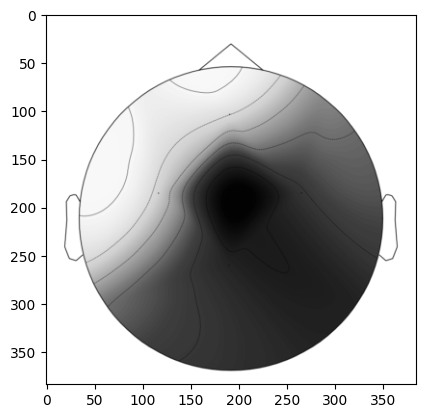

In [7]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
i = 0
img = train_features[i][0].squeeze()
label = train_labels[i]
print(f"Label: {label} len: {len(train_features)}")
plt.imshow(img, cmap="gray")
plt.show()

### Model

In [9]:
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(2048, 3)
# How to add Last Layer to model for classification
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),   #. Add a new linear layer
    nn.Linear(1024, 3)           #. Final linear layer for classification (assuming 3 classes)
)
model.to(device)

# num_classes =  3 # จำนวนคลาส
# model_name = 'vit_base_patch32_384'  # ชื่อของโมเดล ViT
# pretrained = True  # โหลด weights ที่ pretrained มาใช้
# model = timm.create_model(model_name, pretrained=pretrained)
# num_features = model.head.in_features
# model.head = nn.Linear(num_features, num_classes)
# model.to(device)

Using cache found in /home/hpcnc/.cache/torch/hub/pytorch_vision_main
/home/hpcnc/cloud/SuperAI/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hpcnc/cloud/SuperAI/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
num_epochs    = 10
learning_rate = 1e-4

### Training

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader,desc=f"EPOCH : {epoch + 1}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

    # scheduler.step() 

    model.eval()
    correct = 0
    total   = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f} Last Learning Rate {optimizer.param_groups[0]['lr']}")

    val_accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.4f}")
    
    print("--------------------------------------")

EPOCH : 1: 100%|██████████| 76/76 [01:05<00:00,  1.15it/s]


Epoch [1/10], Train Loss: 1.1286 Last Learning Rate 0.0001
Epoch [1/10], Validation Accuracy: 0.3217
--------------------------------------


EPOCH : 2: 100%|██████████| 76/76 [01:05<00:00,  1.16it/s]


Epoch [2/10], Train Loss: 1.1045 Last Learning Rate 0.0001
Epoch [2/10], Validation Accuracy: 0.3193
--------------------------------------


EPOCH : 3: 100%|██████████| 76/76 [01:05<00:00,  1.16it/s]


Epoch [3/10], Train Loss: 1.1035 Last Learning Rate 0.0001
Epoch [3/10], Validation Accuracy: 0.3590
--------------------------------------


EPOCH : 4: 100%|██████████| 76/76 [01:05<00:00,  1.16it/s]


Epoch [4/10], Train Loss: 1.1025 Last Learning Rate 0.0001
Epoch [4/10], Validation Accuracy: 0.3403
--------------------------------------


EPOCH : 5: 100%|██████████| 76/76 [01:05<00:00,  1.16it/s]


Epoch [5/10], Train Loss: 1.0987 Last Learning Rate 0.0001
Epoch [5/10], Validation Accuracy: 0.3217
--------------------------------------


EPOCH : 6: 100%|██████████| 76/76 [01:05<00:00,  1.16it/s]


Epoch [6/10], Train Loss: 1.1034 Last Learning Rate 0.0001
Epoch [6/10], Validation Accuracy: 0.3357
--------------------------------------


EPOCH : 7: 100%|██████████| 76/76 [01:05<00:00,  1.16it/s]


Epoch [7/10], Train Loss: 1.0995 Last Learning Rate 0.0001
Epoch [7/10], Validation Accuracy: 0.3310
--------------------------------------


EPOCH : 8: 100%|██████████| 76/76 [01:05<00:00,  1.16it/s]


Epoch [8/10], Train Loss: 1.0999 Last Learning Rate 0.0001
Epoch [8/10], Validation Accuracy: 0.3357
--------------------------------------


EPOCH : 9: 100%|██████████| 76/76 [01:05<00:00,  1.15it/s]


Epoch [9/10], Train Loss: 1.0976 Last Learning Rate 0.0001
Epoch [9/10], Validation Accuracy: 0.3170
--------------------------------------


EPOCH : 10: 100%|██████████| 76/76 [01:05<00:00,  1.15it/s]


Epoch [10/10], Train Loss: 1.0999 Last Learning Rate 0.0001
Epoch [10/10], Validation Accuracy: 0.3147
--------------------------------------


### Predict

In [15]:
model.eval()
y_train  = []
y_test   = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_train.extend(predicted.tolist())
        y_test.extend(labels.tolist())

y_train


[0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 2,
 0,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 0,


### Confusion Matrix

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_train, y_test,digits=4))

              precision    recall  f1-score   support

           0     0.5168    0.3468    0.4151       222
           1     0.3381    0.3113    0.3241       151
           2     0.1560    0.3929    0.2234        56

    accuracy                         0.3403       429
   macro avg     0.3370    0.3503    0.3209       429
weighted avg     0.4068    0.3403    0.3580       429



Normalized confusion matrix
[[0.35 0.35 0.31]
 [0.35 0.31 0.34]
 [0.34 0.27 0.39]]


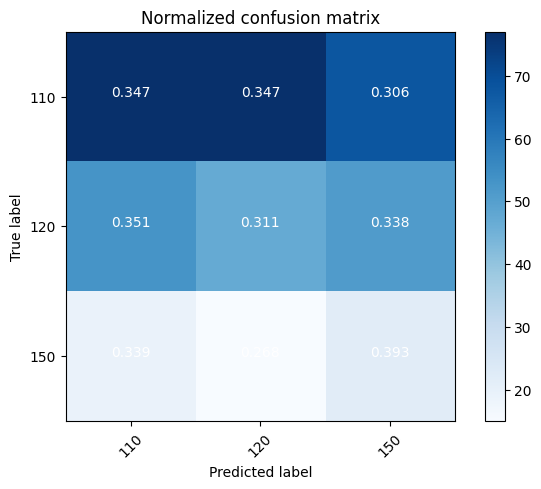

In [17]:
import itertools

class_names = ["110", "120" , "150"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if type(cm[i, j]) == np.int64:
            plt.text(j, i, cm[i, j],
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, f"{cm[i, j]:.3f}",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_train, y_test)
np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()